# Ascent from Lunar Surface

Keywords: optimal control, ipopt usage, dae, differential-algebraic equations, rescaling time

In the previous notebook we landed Apollo 11 on the moon. In this notebook we return from the surface of the moon to lunar orbit so that we can rendezvous with the CSM and return home. Of course in this notebook we only consider the launch problem and not the rendezvous problem.

This is a particularly interesting problem to look at because it allows us to compare a direct approach to optimization as used in pyomo against an indirect approach. We will be looking at example 4.5 from Optimal Control with Aerospace Applications by Longuski et al. In Optimal Control the authors take the indirect approach, using the Euler-Lagrange theorem and Pontryagin's minimum principle to transform the optimization problem into a Boundary Vale Problem (BVP). Here we will use the same problem formulation and solve it using the direct method via pyomo. We will also show the solution via the indirect method but we will not explain the derivation in depth. For that please see Longuski et al.

## Problem formulation
We'll start with the problem formulation which is taken directly from example 4.5 in Optimal Control with Aerospace Applications by Longuski et al.

In the formulation we assume the moon is flat. It's a bit of a strange model because once we achieve orbital velocity in this model we'll just fall right back down to the surface, but that's fine because we're only interested in what happens up the point of reaching orbital velocity/altitude. Despite the simplicity of the model, it was used in the first stage of the Saturn V launch vehicle.

The image below show a depiction of our formulation. Gravity points in the -y direction, the thrust is referred to as F and our control variable is $\alpha$

![Flat Planet Model](figures/flat_moon_model.png)

In this model, as opposed to the previous one, thrust is assumed to be constant and the mass does not vary with time. Longuski et al. do explore models with varying thrust, varying mass, and also atmospheric drag but we leave this to the reader to investigate.

In [53]:
from pyomo.dae import ContinuousSet, DerivativeVar
from pyomo.environ import ConcreteModel, TransformationFactory, Var, \
                          NonNegativeReals, Constraint, \
                          SolverFactory, Objective, cos, sin, minimize, \
                          NonNegativeReals
import numpy as np
import matplotlib.pyplot as plt

# Define parameters of the problem
h = 185.2e3 # meters, final altitude (100 nmi circular orbit)
Vc = 1.627e3 # m/s, Circular speed at 100 nmi
g_accel = 1.62 # m/sˆ2, gravitational acceleration of Moon
Thrust2Weight = 3 # Thrust to Weight ratio for Ascent Vehicle, in lunar G's
F = Thrust2Weight * g_accel

model = ConcreteModel("rocket")
model.T = Var(domain=NonNegativeReals)
model.t = ContinuousSet(bounds=(0, 1))
model.x = Var(model.t, domain=NonNegativeReals)
model.y = Var(model.t, domain=NonNegativeReals)
model.xdot = DerivativeVar(model.x, wrt=model.t, domain=NonNegativeReals)
model.xdoubledot = DerivativeVar(model.xdot, wrt=model.t)
model.ydot = DerivativeVar(model.y, wrt=model.t, domain=NonNegativeReals)
model.ydoubledot = DerivativeVar(model.ydot, wrt=model.t)
model.alpha = Var(model.t, bounds=(-np.pi, np.pi))

# Dynamics
model.xode = Constraint(model.t, rule=lambda m, t: m.xdoubledot[t] == (F*cos(m.alpha[t]))*m.T**2)
model.yode = Constraint(model.t, rule=lambda m, t: m.ydoubledot[t] == (F*sin(m.alpha[t]) - g_accel)*m.T**2)

# Boundary conditions at the initial time
model.x[0].fix(0)
model.y[0].fix(0)
model.xdot[0].fix(0)
model.ydot[0].fix(0)

# Boundary conditions at the final time
model.y[1].fix(h)
# Since our velocity state is dx/dtau instead of dx/dt, we must set it to be the final value of dx/dt (which is Vc)
# multiplied by the final time. Technically ydot needs this as well but fortunately ydotfinal is 0.
model.xdottf = Constraint(model.t, rule=lambda m, t: Constraint.Skip if t != m.t.last() else m.xdot[t] == Vc*m.T)
model.ydot[1].fix(0)


discretizer = TransformationFactory('dae.collocation')
discretizer.apply_to(model, wrt=model.t, nfe=30, ncp=6)
# reduce_collocation_points comes from "pyomo.dae: A Modeling and Automatic Discretization Framework
# for Optimization with Differential and Algebraic Equations"
discretizer.reduce_collocation_points(model, var=model.alpha, ncp=1, contset=model.t)

model.obj = Objective(expr=model.T, sense=minimize)

solver = SolverFactory('ipopt')
results = solver.solve(model)

tf_direct = model.T()
tdirect = [t*tf_direct for t in model.t]
alphadirect = [model.alpha[t]() for t in model.t]
xdirect = [model.x[t]()/1000 for t in model.t]
ydirect = [model.y[t]()/1000 for t in model.t]
xdotdirect = [model.xdot[t]()/tf_direct/1000 for t in model.t]
ydotdirect = [model.ydot[t]()/tf_direct/1000 for t in model.t]
xdoubledotdirect = [model.xdoubledot[t]() for t in model.t]
ydoubledotdirect = [model.ydoubledot[t]() for t in model.t]



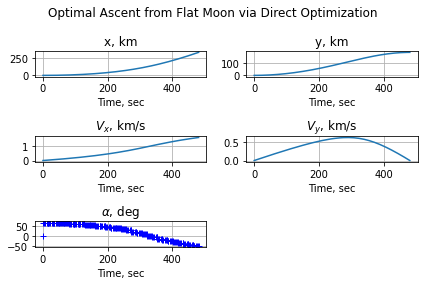

In [54]:
fig = plt.figure()
fig.suptitle('Optimal Ascent from Flat Moon via Direct Optimization')

ax = fig.add_subplot(321)
ax.plot(tdirect, xdirect)
ax.set_title('x, km')
ax.set_xlabel('Time, sec')
ax.grid()

ax = fig.add_subplot(322)
ax.plot(tdirect, ydirect)
ax.set_title('y, km')
ax.set_xlabel('Time, sec')
ax.grid()

ax = fig.add_subplot(323)
ax.plot(tdirect, xdotdirect)
ax.set_title(r'$V_x$, km/s')
ax.set_xlabel('Time, sec')
ax.grid()

ax = fig.add_subplot(324)
ax.plot(tdirect, ydotdirect)
ax.set_title(r'$V_y$, km/s')
ax.set_xlabel('Time, sec')
ax.grid()

ax = fig.add_subplot(325)
ax.plot(tdirect, np.rad2deg(alphadirect), 'b+')
ax.set_title(r'$\alpha$, deg')
ax.set_xlabel('Time, sec')
ax.grid()

plt.tight_layout()
plt.show()

And now we look at the solution via the indirect approach. 

In [56]:
# Optimal Ascent Problem with Python's solve_bvp
#
# Original script for MATLAB's bvp4c by by Jose J. Guzman and George E. Pollock
#
# Adapted for Python by Nickolai Belakovski
#
# This script uses scipy's solve_bvp to solve the problem of finding the
# optimal ascent trajectory for launch from a flat Moon to a 100 nautical
# mile circular orbit.


import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt


# Define parameters of the problem
h = 185.2e3  # meters, final altitude (100 nmi circular orbit)
Vc = 1.627e3  # m/s, Circular speed at 100 nmi
g_accel = 1.62  # m/sˆ2, gravitational acceleration of Moon
Thrust2Weight = 3  # Thrust to Weight ratio for Ascent Vehicle, in lunar G's
# ----------------------------------------------------------------------------
# Boundary Conditions
# ----------------------------------------------------------------------------
# Initial conditions
# Launch from zero altitude with zero initial velocity
xi_d = 0  # meters, initial x-position (_d means 'desired')
yi_d = 0  # meters, initial y-position
Vxi_d = 0  # m/s, initial downrange velocity
Vyi_d = 0  # m/s, initial vertical velocity
# Final conditions
yf_d = h  # meters, final altitude
Vxf_d = Vc  # m/s, final downrange velocity
Vyf_d = 0  # m/s, final vertical velocity
Hf_d = -1


# Note: this function uses g_accel and Thrust2Weight and so must be defined
# after those two variables
def ascent_odes_tf(tau, X, tf):
    #
    # State and Costate Differential Equation Function for the Flat-Moon
    # Optimal Ascent Problem
    #
    #
    # The independent variable here is the nondimensional time, tau, the state
    # vector is X, and the final time, tf, is an unknown parameter that must
    # also be passed to the DE function.
    # Note that the state vector X has components
    # X[0] = x, horizontal component of position
    # X[1] = y, vertical component of position
    # X[2] = Vx, horizontal component of velocity
    # X[3] = Vy, vertical component of velocity
    # X[4] = lambda2
    # X[5] = lambda3
    # X[6] = lambda4
    # Acceleration (F/m) of the Ascent Vehicle, m/s^2
    Acc = Thrust2Weight*g_accel
    # State and Costate differential equations in terms of d/dt:
    # x and y are unused but we label them anyway for completeness and also debugging
    x = X[0]  # noqa
    y = X[1]  # noqa
    Vx = X[2]
    Vy = X[3]
    lambda2 = X[4]
    lambda3 = X[5]
    lambda4 = X[6]
    xdot = Vx
    ydot = Vy
    Vxdot = Acc*(-lambda3/np.sqrt(lambda3**2+lambda4**2))
    Vydot = Acc*(-lambda4/np.sqrt(lambda3**2+lambda4**2)) - g_accel
    lambda2_dot = np.zeros(X.shape[1])
    lambda3_dot = np.zeros(X.shape[1])
    lambda4_dot = -lambda2
    # Nondimensionalize time (with tau = t/tf and d/dtau = tf*d/dt). We must
    # multiply each differential equation by tf to convert our derivatives from
    # d/dt to d/dtau.
    dX_dtau = tf*np.array([xdot, ydot, Vxdot, Vydot, lambda2_dot, lambda3_dot, lambda4_dot])
    return dX_dtau


# Note: this function uses the initial and final boundary conditions and so
# must be defined after those variables are defined
def ascent_bcs_tf(Y0, Yf, tf):
    # Boundary Condition Function for the Flat-Moon Optimal Ascent Problem
    # Hamiltonian final needs to be -1
    xi = Y0[0]
    yi = Y0[1]
    Vxi = Y0[2]
    Vyi = Y0[3]
    lambda2i = Y0[4]  # noqa
    lambda3i = Y0[5]  # noqa
    lambda4i = Y0[6]  # noqa

    xf = Yf[0]  # noqa
    yf = Yf[1]
    Vxf = Yf[2]
    Vyf = Yf[3]
    lambda2f = Yf[4]
    lambda3f = Yf[5]
    lambda4f = Yf[6]

    costhetaf = -lambda3f/np.sqrt(lambda3f**2 + lambda4f**2)
    sinthetaf = -lambda4f/np.sqrt(lambda3f**2 + lambda4f**2)
    Acc = Thrust2Weight*g_accel
    Hf = lambda2f*Vxf + lambda3f * Acc * costhetaf + lambda4f * Acc * sinthetaf - lambda4f*g_accel
    PSI = np.array([
        xi - xi_d,
        yi - yi_d,
        Vxi - Vxi_d,
        Vyi - Vyi_d,
        yf - yf_d,
        Vxf - Vxf_d,
        Vyf - Vyf_d,
        Hf - Hf_d
    ])
    return PSI


# ----------------------------------------------------------------------------
# Initial Guesses
# ----------------------------------------------------------------------------
# list initial conditions in yinit, use zero if unknown
yinit = [xi_d, yi_d, Vxi_d, Vyi_d, 0, 1, 1]  # guess for initial state and costate variables
tf_guess = 700  # sec, initial guess for final time

# Because the final time is free, we must parameterize the problem by
# the unknown final time, tf. Create a nondimensional time vector,
# tau, with Nt linearly spaced elements. (tau = time/tf) We will pass the
# unknown final time to solve_bvp as an unknown parameter and the code will
# attempt to solve for the actual final time as it solves our TPBVP.
Nt = 41
tau = np.linspace(0, 1, Nt)  # nondimensional time vector
# Create an initial guess of the solution. For some BVPs it can be useful to ensure
# that the initial guess satisfies both the initial and final boundary conditions
# but for this problem we can simply copy the initial states across the time mesh
# because it's not too sensitive to the initial guess
solinit = np.array([yinit for _ in range(Nt)]).T
# ----------------------------------------------------------------------------
# Solution
# ----------------------------------------------------------------------------
sol = solve_bvp(ascent_odes_tf, ascent_bcs_tf, tau, solinit, np.array([tf_guess]))
# Extract the final time from the solution:
tf_indirect = sol.p[0]
# Evaluate the solution at all times in the nondimensional time vector tau
# and store the state variables in the matrix Z.
Z = sol.sol(tau)
# Convert back to dimensional time for plotting
tindirect = tau*tf_indirect
# Extract the solution for each state variable from the matrix Z:
xindirect = Z[0, :] / 1000
yindirect = Z[1, :] / 1000
xdotindirect = Z[2, :] / 1000
ydotindirect = Z[3, :] / 1000
lambda2_sol = Z[4, :]
lambda3_sol = Z[5, :]
lambda4_sol = Z[6, :]
alphaindirect = np.arctan2(-lambda4_sol, -lambda3_sol)


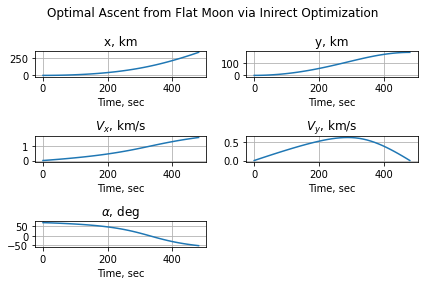

In [58]:
# Plots
fig = plt.figure()
fig.suptitle('Optimal Ascent from Flat Moon via Inirect Optimization')

ax = fig.add_subplot(321)
ax.plot(tindirect, xindirect)
ax.set_title('x, km')
ax.set_xlabel('Time, sec')
ax.grid()

ax = fig.add_subplot(322)
ax.plot(tindirect, yindirect)
ax.set_title('y, km')
ax.set_xlabel('Time, sec')
ax.grid()

ax = fig.add_subplot(323)
ax.plot(tindirect, xdotindirect)
ax.set_title(r'$V_x$, km/s')
ax.set_xlabel('Time, sec')
ax.grid()

ax = fig.add_subplot(324)
ax.plot(tindirect, ydotindirect)
ax.set_title(r'$V_y$, km/s')
ax.set_xlabel('Time, sec')
ax.grid()

ax = fig.add_subplot(325)
ax.plot(tindirect, np.rad2deg(alphaindirect))
ax.set_title(r'$\alpha$, deg')
ax.set_xlabel('Time, sec')
ax.grid()

plt.tight_layout()
plt.show()

Finally, we compare the two solutions.

In [59]:

from scipy.interpolate import interp1d

# We'll consider the indirect approach to be the "true" solution
# It's not exactly analytical since we had to use a numerical BVP
# solver to obtain the solution, but given the fact that it is the
# optimal BVP to solve it is fair to use it as truth
tf_err = abs(tf_direct - tf_indirect)/tf_indirect*100

# To compare simulation parameters we interpolate both solutions
xdirectinterp = interp1d(tdirect, xdirect)
ydirectinterp = interp1d(tdirect, ydirect)
xdotdirectinterp = interp1d(tdirect, xdotdirect)
ydotdirectinterp = interp1d(tdirect, ydotdirect)
alphadirectinterp = interp1d(tdirect, alphadirect)

xindirectinterp = interp1d(tindirect, xindirect)
yindirectinterp = interp1d(tindirect, yindirect)
xdotindirectinterp = interp1d(tindirect, xdotindirect)
ydotindirectinterp = interp1d(tindirect, ydotindirect)
alphaindirectinterp = interp1d(tindirect, alphaindirect)



Percent error in final time: 0.01581866075745914 %
tf_direct: 481.2800616637531, tf_indirect: 481.2039416446728


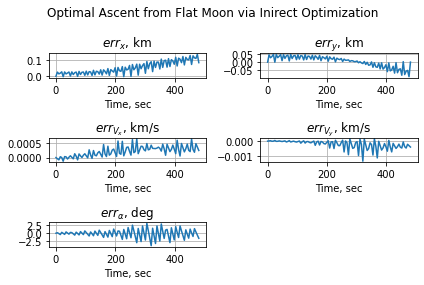

In [60]:
print("Percent error in final time:", tf_err, "%")
print(f"tf_direct: {tf_direct}, tf_indirect: {tf_indirect}")

teval = np.linspace(0, min(tf_direct, tf_indirect), 100)
errx = xindirectinterp(teval) - xdirectinterp(teval)
erry = yindirectinterp(teval) - ydirectinterp(teval)
errxdot = xdotindirectinterp(teval) - xdotdirectinterp(teval)
errydot = ydotindirectinterp(teval) - ydotdirectinterp(teval)
erralpha = alphaindirectinterp(teval) - alphadirectinterp(teval)
erralpha[0] = 0 # We override the initial error to scale the graph appropraites

fig = plt.figure()
fig.suptitle('Optimal Ascent from Flat Moon via Inirect Optimization')

ax = fig.add_subplot(321)
ax.plot(teval, errx)
ax.set_title(r'$err_x$, km')
ax.set_xlabel('Time, sec')
ax.grid()

ax = fig.add_subplot(322)
ax.plot(teval, erry)
ax.set_title(r'$err_y$, km')
ax.set_xlabel('Time, sec')
ax.grid()

ax = fig.add_subplot(323)
ax.plot(teval, errxdot)
ax.set_title(r'$err_{V_x}$, km/s')
ax.set_xlabel('Time, sec')
ax.grid()

ax = fig.add_subplot(324)
ax.plot(teval, errydot)
ax.set_title(r'$err_{V_y}$, km/s')
ax.set_xlabel('Time, sec')
ax.grid()

ax = fig.add_subplot(325)
ax.plot(teval, np.rad2deg(erralpha))
ax.set_title(r'$err_{\alpha}$, deg')
ax.set_xlabel('Time, sec')
ax.grid()

plt.tight_layout()
plt.show()

The difference in final time is negligible.

We see that the difference in the control angle $\alpha$ gets up to 2.5 degrees, and we have ignored the initial value where the direct approach chose to keep it at 0. The result is that the difference in downrange distance gets to be over 100 meters, but in the other 3 variables, which are more important to us as we set boundary conditions on those (we may care about downrange distance for the rendezvous case but we're not concerned with it here), we see rather small errors.